In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import gym # openAi gym
from gym import envs
import numpy as np
import tensorflow as tf
import imageio

In [3]:
class OUActionNoise(object):
    def __init__(self, mu, signma = 0.15, theta=0.2,dt=1e-2, x0=None):
        self.theta  =  theta

In [4]:
import tensorflow as tf

In [5]:
tf.compat.v1.enable_v2_behavior()

In [6]:
!apt-get install python-opengl -y
!pip install pyvirtualdisplay




The following additional packages will be installed:
  freeglut3 libglu1-mesa
Suggested packages:
  python-numpy libgle3
The following NEW packages will be installed:
  freeglut3 libglu1-mesa python-opengl
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 738 kB of archives.
After this operation, 6207 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libglu1-mesa amd64 9.0.0-2.1build1 [168 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 738 kB in 2s (320 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 100757 files and directories currently installed.)
Preparing to unpack .../freeglut3_2.8.1-3_amd64.deb ...
Unpacking freeglut3:amd64 (2.8.1-3) .

In [7]:
import  pyvirtualdisplay  as pyv

In [8]:
display = pyv.Display(visible=0, size=(1400,900)).start()

In [9]:
!pip install tf_agents==0.6.0



     |████████████████████████████████| 1.1 MB 413 kB/s 
     |████████████████████████████████| 46 kB 2.4 MB/s 
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.6.0
    Uninstalling cloudpickle-1.6.0:
      Successfully uninstalled cloudpickle-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2021.4.0 requires cloudpickle>=1.5.0, but you have cloudpickle 1.3.0 which is incompatible.


In [10]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval  import metric_utils
from tf_agents.networks import q_network
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [11]:
#Hyperparameters

num_iterations = 20000
initial_collect_step = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200


num_eval_episodes = 10
eval_interval = 1000


In [12]:
#environment

env_name = "CartPole-v0"
env = suite_gym.load(env_name)

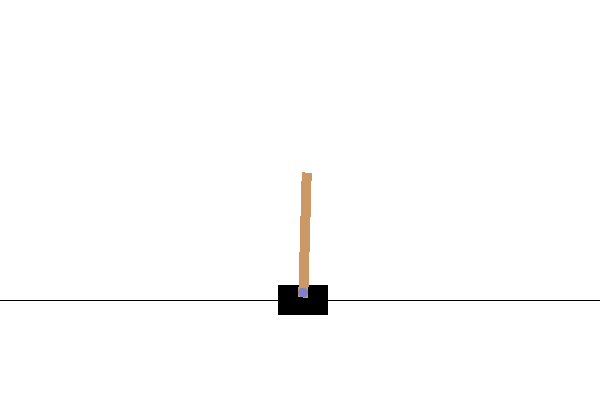

In [13]:
import PIL
env.reset()   # setting  initial env 
PIL.Image.fromarray(env.render())

In [14]:
print("observation Spec:/n")  # array of 4  (cart : position, velo; poll: ang positio, ang  velo)
print(env.time_step_spec().observation)

observation Spec:/n
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [15]:
print("reward spec:/n")   # scalar float
print(env.time_step_spec().reward)

reward spec:/n
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [16]:
print("action spec:/n"
     )     # 2  possible value 0-- left, 1--right
print(env.action_spec())

action spec:/n
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [17]:
import numpy as np
time_step = env.reset()

print("Time Step :", time_step)


action = np.array(1, dtype= np.int32)
print()
#for i in range(55500000):
next_time_step = env.step(action)
print("Next time step:", next_time_step)

Time Step : TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.04954891, -0.01705808, -0.00066431, -0.01842035], dtype=float32))

Next time step: TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.04920775,  0.17807339, -0.00103272, -0.3113128 ], dtype=float32))


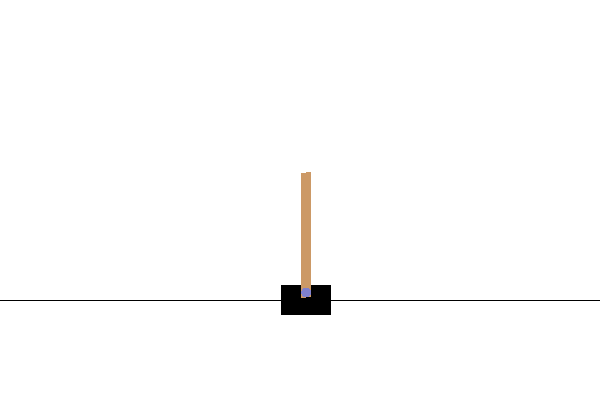

In [18]:
PIL.Image.fromarray(env.render())

In [19]:
train_py_env = suite_gym.load(env_name)   #train env
eval_py_env = suite_gym.load(env_name)    #val env

In [20]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)    #tf suitable form

In [21]:
#q network

fc_layer_params = (100,)   #hidden  layers 

q_net = q_network.QNetwork(train_env.observation_spec(), train_env.action_spec(), fc_layer_params =  fc_layer_params   )

In [22]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate= learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(train_env.time_step_spec(), train_env.action_spec(), q_network=q_net, optimizer=optimizer, td_errors_loss_fn=common.element_wise_squared_loss, 
                           train_step_counter= train_step_counter )

agent.initialize()

In [23]:
#policy two type: -- main used for evalution and deployment,  seconf that used to data collection

eval_policy = agent.policy
collect_policy = agent.collect_policy



In [24]:
#random policy independent of agent
random_policy =  random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),  train_env.action_spec())

In [25]:
example_environment = tf_py_environment.TFPyEnvironment( suite_gym.load("CartPole-v0"))

In [26]:
time_step = example_environment.reset()

In [27]:
actl = random_policy.action(time_step)   #get action from policy bby giving time_step

actl

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

In [28]:
time_step = example_environment.step(actl.action)

In [29]:
print(time_step)

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03788718,  0.16904636,  0.01428416, -0.28479466]],
      dtype=float32)>)


In [30]:
#matrics and evalution
def compute_avg_return(environment, policy, num_episodes=10):
    
    total_return = 0.0
    
    for _ in range (num_episodes):
        
        time_step = environment.reset()
        
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            
            time_step = environment.step(action_step.action)
            
            episode_return += time_step.reward
            
        total_return += episode_return
        
        
    avg_return = total_return/num_episodes
    
    return avg_return.numpy()[0]

In [31]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

21.3

In [32]:
#replay buffer
replay_buffer =  tf_uniform_replay_buffer.TFUniformReplayBuffer( data_spec = agent.collect_data_spec,
                                                               batch_size = train_env.batch_size,
                                                               max_length= replay_buffer_max_length)


In [33]:
agent.collect_data_spec._fields



('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [34]:
#data collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    
    buffer.add_batch(traj)
    
    
def collect_data(env, policy, buffer, steps):
    
    for _ in range(steps):
        collect_step(env, policy, buffer)

        
        
collect_data(train_env, random_policy, replay_buffer, steps=100)

In [35]:
#replay buffer iter

iter(replay_buffer.as_dataset()).next()

(Trajectory(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, observation=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.02155502, -0.03163044,  0.11333431,  0.424236  ], dtype=float32)>, action=<tf.Tensor: shape=(), dtype=int64, numpy=0>, policy_info=(), next_step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, discount=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>),
 BufferInfo(ids=<tf.Tensor: shape=(), dtype=int64, numpy=22>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.01>))

In [36]:
#create dataset (two adjacent rows  num_step=2)

dataset = replay_buffer.as_dataset(num_parallel_calls=3,
                                  sample_batch_size=batch_size,
                                  num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [37]:
iterator = iter(dataset)

iterator.next()

(Trajectory(step_type=<tf.Tensor: shape=(64, 2), dtype=int32, numpy=
 array([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [2, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 2],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 2],
        [2, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [2, 0],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [2, 0],
        [1, 2],
        [1, 1],
   

In [38]:
#training the agent
#two steps : - 1) collect data from env and 2)  use the data to train the agent's NN
agent.train = common.function(agent.train)

#reset the train step
agent.train_step_counter.assign(0)

#evalute policy before training
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]


for _ in range(num_iterations):
    
    # collect a few step to save in replay buffer
    for _ in range (collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
        
    #get next data from dataset and updtae agent's network
    experience, unused_info =  next(iterator)
    
    train_loss = agent.train(experience).loss
    
    step = agent.train_step_counter.numpy()
    
    
    if step % log_interval == 0:
        print('step = {0} : loss = {1}'.format(step, train_loss))
        
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        
        print('step = {0} : Avg Return :{1}'.format(step, avg_return))
        
        returns.append(avg_return)



step = 200 : loss = 8.27884578704834
step = 400 : loss = 9.018061637878418
step = 600 : loss = 2.518127679824829
step = 800 : loss = 9.54608154296875
step = 1000 : loss = 14.952600479125977
step = 1000 : Avg Return :68.0
step = 1200 : loss = 21.155776977539062
step = 1400 : loss = 15.481598854064941
step = 1600 : loss = 51.485721588134766
step = 1800 : loss = 16.075592041015625
step = 2000 : loss = 47.84305191040039
step = 2000 : Avg Return :24.600000381469727
step = 2200 : loss = 32.73166275024414
step = 2400 : loss = 49.20347595214844
step = 2600 : loss = 17.703319549560547
step = 2800 : loss = 18.750560760498047
step = 3000 : loss = 38.32825469970703
step = 3000 : Avg Return :55.79999923706055
step = 3200 : loss = 83.83592987060547
step = 3400 : loss = 5.414161682128906
step = 3600 : loss = 20.65662384033203
step = 3800 : loss = 46.21671676635742
step = 4000 : loss = 20.64519691467285
step = 4000 : Avg Return :155.60000610351562
step = 4200 : loss = 63.89645767211914
step = 4400 : l

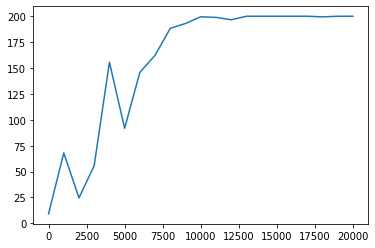

In [39]:
iterations =  range(0, num_iterations + 1, eval_interval)

import matplotlib.pyplot as plt

plt.plot(iterations, returns)



In [40]:
import base64

In [41]:
#let's create video

def embed_mp4(filename):
    
    video = open(filename, 'rb').read()
    
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src ="data:video/mp4;base64,{0}" type="video/mp">
    your browswr does nt support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)
    
    

In [42]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [43]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return    embed_mp4(filename)   #YouTubeVideo(filename, width=1000, height=450)# play(filename)



In [44]:
!pip install imageio-ffmpeg

     |████████████████████████████████| 26.9 MB 8.8 MB/s 


In [45]:
import IPython

In [46]:
import imageio

In [47]:
create_policy_eval_video(agent.policy, "cartpole_dqn_trained-agent")

#embed_mp4(cartpole_dqn_trained-agent.mp4 )


In [48]:
from IPython.display import YouTubeVideo

In [49]:
from IPython import display


In [50]:
display.YouTubeVideo(id='1U3Aqx-ta8AcmzAU' , height=450, width=1000)